# Loading Dataset

In [1]:
import seaborn as sns
from sklearn.model_selection import train_test_split
from collections import Counter
from tensorflow import keras
from tensorflow.keras import Sequential
from tensorflow.keras import layers
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50


from tensorflow.keras import regularizers
from keras.layers.core import Dropout
import keras_tuner

import os
import pandas as pd
import numpy as np
from PIL import Image
import matplotlib.pyplot as plt

from itertools import cycle
from sklearn.metrics import RocCurveDisplay
from sklearn.preprocessing import LabelBinarizer
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.metrics import auc, roc_curve
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import classification_report

import warnings
warnings.filterwarnings("ignore")

Using TensorFlow backend


In [2]:
import tensorflow as tf

print(tf.__version__)
print(tf.config.list_physical_devices('GPU'))

2.10.1
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
data = np.load("data.npy")
labels = np.load("labels.npy", allow_pickle=True)
class_labels = np.load("labels_name.npy")

## Preprocessing

In [3]:
# General information
print("The shape of the data is: ", data.shape)
print("The number of data labels: ", len(labels))
print("The number of class labels: ", len(np.unique(class_labels)))
print("The data type: ", data.dtype)

The shape of the data is:  (10015, 150, 120, 3)
The number of data labels:  10015
The number of class labels:  7
The data type:  uint8


In [4]:
# Class labels
print(np.unique(class_labels))

['Acaic' 'Basal cell carcinoma' 'Benign keratosis-like lesions'
 'Dermatofibroma' 'Melanocytic nevi' 'Melanoma' 'Vascular lesions']


In [4]:
# train-validation-test split
X_trainval, X_test, Y_trainval, Y_test= train_test_split(data, labels, test_size=0.20, train_size =0.8, 
                                                   random_state=42, stratify=labels)
X_train, X_validation, Y_train, Y_validation = train_test_split(X_trainval,Y_trainval,test_size = 0.2,train_size =0.8, 
                                                                random_state=42, stratify=Y_trainval)

In [6]:
# General information after trian -validation-test split
print("X_train.shape", X_train.shape)
print("y_train.shape", Y_train.shape)
print("X_validation.shape", X_validation.shape)
print("y_validation.shape", Y_validation.shape)
print("Y_test.shape", Y_test.shape)
print("X_test.shape", X_test.shape)
print("Y_test.shape", Y_test.shape)

X_train.shape (6409, 150, 120, 3)
y_train.shape (6409, 7)
X_validation.shape (1603, 150, 120, 3)
y_validation.shape (1603, 7)
Y_test.shape (2003, 7)
X_test.shape (2003, 150, 120, 3)
Y_test.shape (2003, 7)


In [5]:
# normalize to range 0-1 (im - np.amin(im)) /(np.amax(im)-np.amin(im)) 
amin = np.amin(X_train)
amax = np.amax(X_train)

X_train = X_train.astype('float32')
X_test = X_test.astype("float32")
X_train = (X_train - amin) /(amax - amin) 
X_validation = (X_validation - amin) /(amax - amin) 
X_test = (X_test - amin) /(amax - amin) 

# Convert also the target labels to floats
Y_train = Y_train.astype("float32")
Y_validation = Y_validation.astype("float32")
Y_test = Y_test.astype("float32")

# Visualizing Sample images

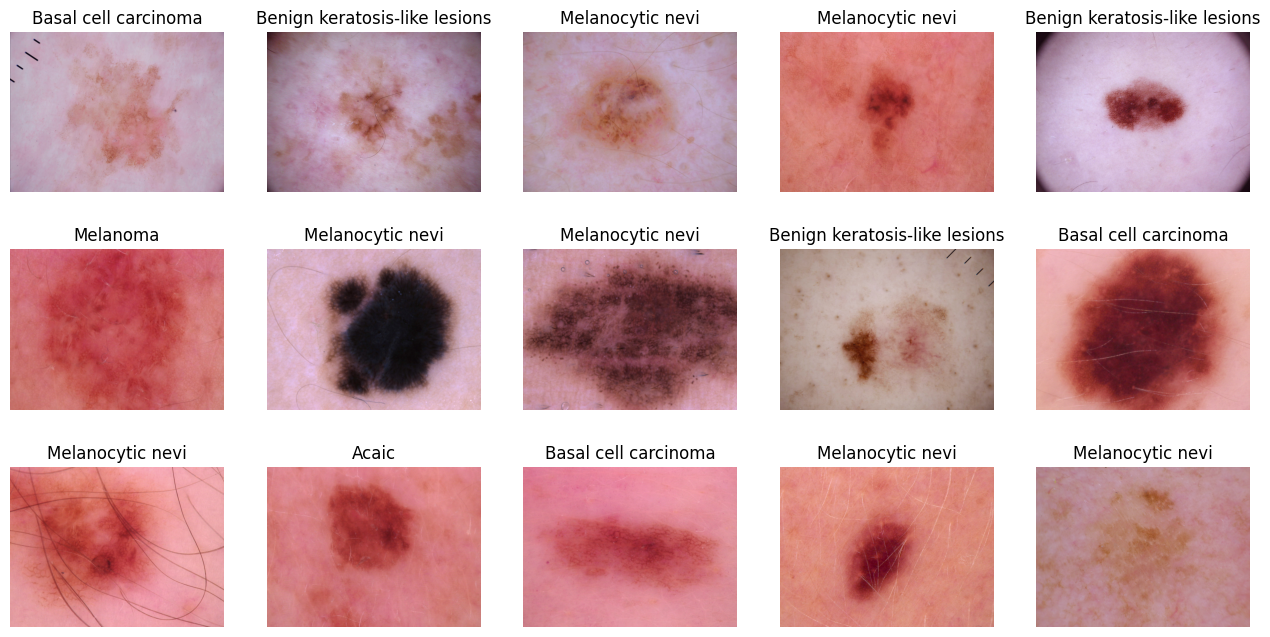

In [8]:
np.random.seed(0)
# The following code is adopted from: https://stackoverflow.com/questions/67862279/taking-a-sample-of-the-image-dataset
image_dir = 'ISIC2018_Task3_Training_Input/'
images = os.listdir(image_dir)
number_of_images = 15 / len(labels)
n_test_images = int(len(images) * (number_of_images)) 
subset_images = np.random.choice(images, size=n_test_images)


plt.figure(figsize=(16, 8))
for i, img_name in enumerate(subset_images):
    plt.subplot(3, 5, i + 1)
    image_path = os.path.join(image_dir, img_name)
    img = plt.imread(image_path)
    plt.imshow(img)
    plt.axis("off")
    index = images.index(img_name)
    class_label = class_labels[index]
    plt.title(class_label)

plt.show()


# Visualize Class Label Distribution

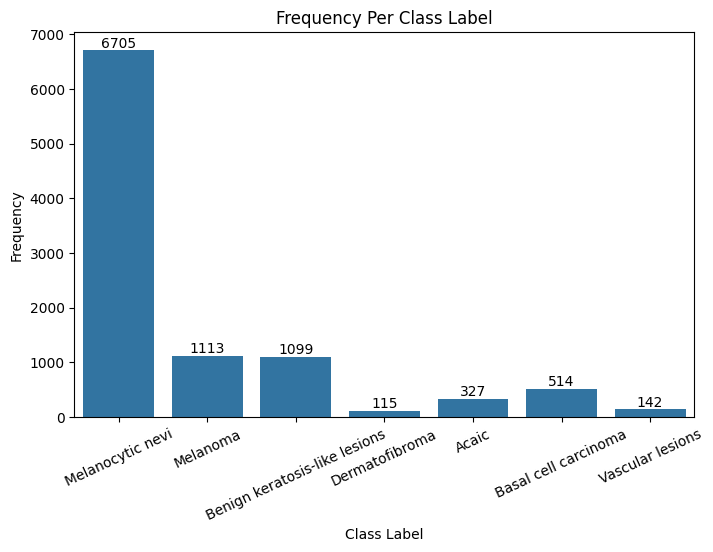

In [9]:
# Frequency of each class label 
class_counts = Counter(class_labels) 

class_label_distribution = pd.DataFrame([class_counts]).transpose()
class_label_distribution.rename(columns={0: "Count"}, inplace = True)

plt.rcParams["figure.figsize"] = (8,5)
ax = sns.barplot(x = class_label_distribution.index , y = "Count", data = class_label_distribution,)
plt.xlabel('Class Label')
plt.ylabel('Frequency')
plt.title('Frequency Per Class Label')
plt.xticks(rotation=25)

# The following code is adopted from: https://stackoverflow.com/questions/25447700/annotate-bars-with-values-on-pandas-bar-plots 
for container in ax.containers:
    ax.bar_label(container)

# Baseline Model

In [6]:
with tf.device('/cpu:0'):
    tX_train = tf.convert_to_tensor(X_train, np.float32)
    tY_train = tf.convert_to_tensor(Y_train, np.float32)
    tX_test = tf.convert_to_tensor(X_test, np.float32)
    tY_test = tf.convert_to_tensor(Y_test, np.float32)
    tX_validation = tf.convert_to_tensor(X_validation, np.float32)
    tY_validation = tf.convert_to_tensor(Y_validation, np.float32)
    del X_train
    del Y_train
    del X_test
    del Y_test
    del X_validation
    del Y_validation

In [30]:
## l1 cause imbalance
def build_model():
    model = Sequential()
    # Convolutional and pooling layers:
    model.add(layers.Conv2D(64, (3, 3), padding = "same", activation = "relu", input_shape = tX_train.shape[1:]))
    model.add(layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    model.add(layers.Conv2D(64, (3, 3), padding = "same", activation = "relu"))
    model.add(layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"))
    model.add(layers.MaxPooling2D((2, 2)))
    # Flatten layer:
    model.add(layers.Flatten())
    # Dense layers:
    model.add(layers.Dense(32, activation = "relu"))
    model.add(layers.Dense(32, activation = "relu"))
    
    # Output layer:
    model.add(layers.Dense(7, activation = "softmax"))
    # Compiling model:
    model.compile(optimizer = "adam",
                  loss = "categorical_crossentropy",
                  metrics = ["accuracy"])
    return model
baseline = build_model()
baseline.summary()

Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_12 (Conv2D)          (None, 150, 120, 64)      1792      
                                                                 
 conv2d_13 (Conv2D)          (None, 150, 120, 32)      18464     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 75, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_14 (Conv2D)          (None, 75, 60, 64)        18496     
                                                                 
 conv2d_15 (Conv2D)          (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 37, 30, 32)       0         
 2D)                                                  

In [13]:
# Fitting model:
history = baseline.fit(tX_train, tY_train, epochs = 10, batch_size = 32, validation_data = (tX_validation, tY_validation))
test_loss, test_acc = baseline.evaluate(tX_test, tY_test)

Epoch 1/10
201/201 [==============================] - 28s 80ms/step - loss: 1.0300 - accuracy: 0.6678 - val_loss: 0.9529 - val_accuracy: 0.6694
Epoch 2/10
201/201 [==============================] - 15s 73ms/step - loss: 0.9438 - accuracy: 0.6692 - val_loss: 0.9654 - val_accuracy: 0.6725
Epoch 3/10
201/201 [==============================] - 15s 73ms/step - loss: 0.9006 - accuracy: 0.6722 - val_loss: 0.9014 - val_accuracy: 0.6775
Epoch 4/10
201/201 [==============================] - 15s 73ms/step - loss: 0.8675 - accuracy: 0.6904 - val_loss: 0.8303 - val_accuracy: 0.6794
Epoch 5/10
201/201 [==============================] - 15s 73ms/step - loss: 0.8358 - accuracy: 0.6951 - val_loss: 0.9204 - val_accuracy: 0.6794
Epoch 6/10
201/201 [==============================] - 15s 73ms/step - loss: 0.8079 - accuracy: 0.7054 - val_loss: 0.8284 - val_accuracy: 0.6918
Epoch 7/10
201/201 [==============================] - 15s 73ms/step - loss: 0.7639 - accuracy: 0.7224 - val_loss: 0.8131 - val_accuracy:

In [14]:
print("val_accuracy:", np.mean(history.history["val_accuracy"]), "val_loss:", np.mean(history.history["val_loss"]))

val_accuracy: 0.6840923309326172 val_loss: 0.8676057696342468


In [15]:
print("test_accuracy", test_acc, "test_loss:",test_loss )

test_accuracy 0.7084373235702515 test_loss: 0.8144094347953796


In [17]:
### Plot of training and validation:
def plot_diagnostics(history):
    # Plot accuracy:
    plt.figure(figsize = (12, 8))
    plt.subplot(221)
    plt.title("Accuracy of model")
    plt.plot(history.history["accuracy"], color = "blue", label = "train")
    plt.plot(history.history["val_accuracy"], color = "orange", label = "validation")
    
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend(["training_accuracy", "validation_accuracy"], loc = "upper left")
    # Plot loss:
    plt.subplot(222)
    plt.title("Loss of model")
    plt.plot(history.history["loss"], color = "blue", label = "train")
    plt.plot(history.history["val_loss"], color = "orange", label = "validation")
    plt.xlabel("Epochs")
    plt.ylabel("Loss")
    plt.legend(["training_loss", "validation_loss"], loc = "upper right")
    plt.show()


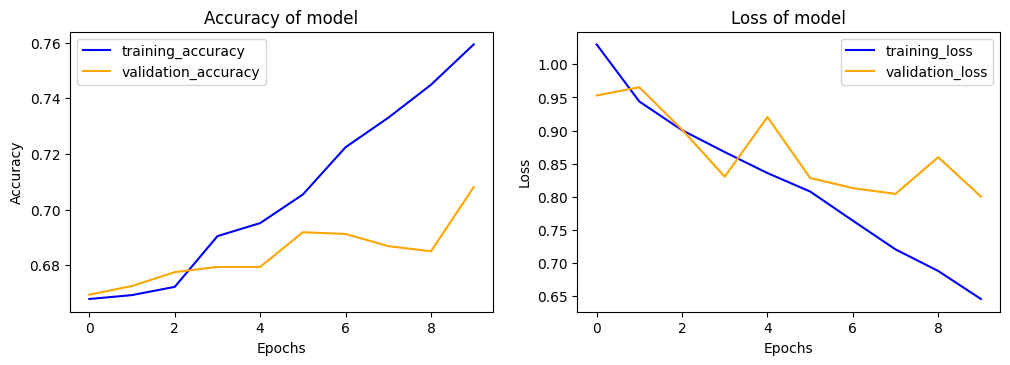

In [17]:
plot_diagnostics(history)

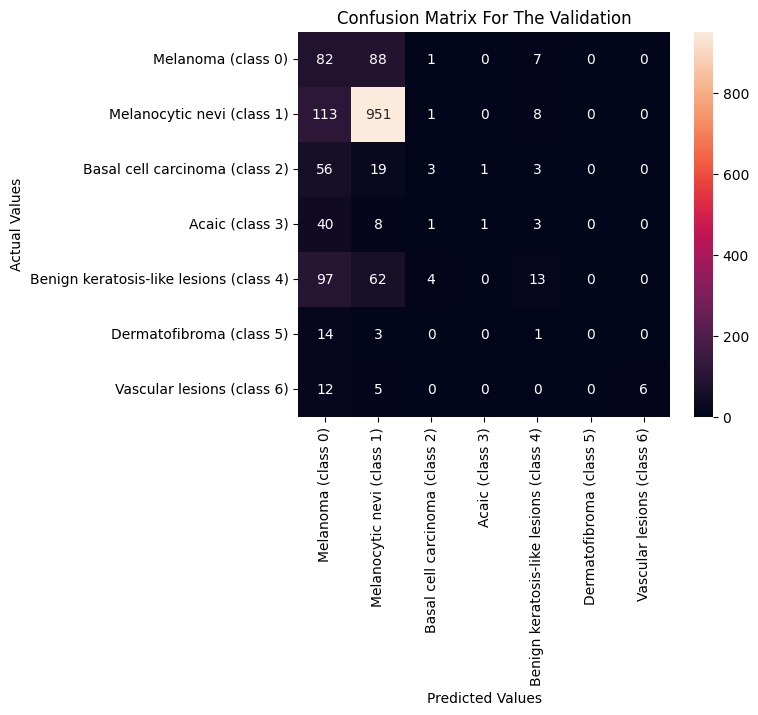

In [18]:
# Confusion matrix for Validiation data
# predict probabilities for test set
yhat_probs = baseline.predict(tX_validation, verbose=0)

# predict classes for test set
pred_validation=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_validation,axis=1), tf.argmax(pred_validation,axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Validation')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

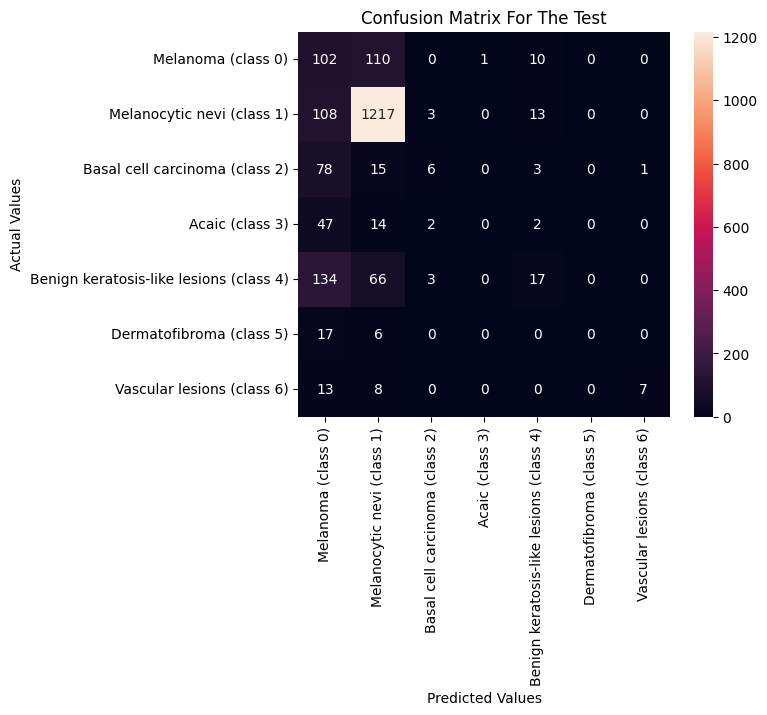

In [19]:
# Confusion matrix for the test data
# predict probabilities for test set
yhat_probs = baseline.predict(tX_test, verbose=0)

# predict classes for test set
pred_test=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_test, axis=1), tf.argmax(pred_test,axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Test')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [16]:
target_names = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)']


def roc_auc(pred, dataset, title):
    n_classes = len(np.unique(class_labels))
    label_binarizer = LabelBinarizer().fit(dataset)
    class_id = label_binarizer.classes_


    # store the fpr, tpr, and roc_auc for all averaging strategies
    fpr, tpr, roc_auc = dict(), dict(), dict()
    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(tf.experimental.numpy.ravel(dataset), tf.experimental.numpy.ravel(pred))
    roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

    print(f"Micro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['micro']:.2f}")


    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(dataset[:, i], pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    fpr_grid = np.linspace(0.0, 1.0, 1000)

    # Interpolate all ROC curves at these points
    mean_tpr = np.zeros_like(fpr_grid)

    for i in range(n_classes):
        mean_tpr += np.interp(fpr_grid, fpr[i], tpr[i])  # linear interpolation

    # Average it and compute AUC
    mean_tpr /= n_classes

    fpr["macro"] = fpr_grid
    tpr["macro"] = mean_tpr
    roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

    print(f"Macro-averaged One-vs-Rest ROC AUC score:\n{roc_auc['macro']:.2f}")
    # this code is adopted from: https://scikit-learn.org/stable/auto_examples/model_selection/plot_roc.html

    fig, ax = plt.subplots(figsize=(12, 7))

    plt.plot(
        fpr["micro"],
        tpr["micro"],
        label=f"micro-average ROC curve (AUC = {roc_auc['micro']:.2f})",
        color="deeppink",
        linestyle=":",
        linewidth=4,
    )
    

    plt.plot(
        fpr["macro"],
        tpr["macro"],
        label=f"macro-average ROC curve (AUC = {roc_auc['macro']:.2f})",
        color="navy",
        linestyle=":",
        linewidth=4,
    )

    colors = cycle(["aqua", "darkorange", "cornflowerblue", "red", "lightblue", "black", "yellowgreen", "blue", "red"])
    for class_id, color in zip(range(n_classes), colors):
        RocCurveDisplay.from_predictions(
            dataset[:, class_id],
            pred[:, class_id],
            name=f"ROC curve for {np.unique(target_names)[class_id]}",
            color=color,
            ax=ax
        )

    plt.axis("square")
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")
    plt.title("Receiver Operating Characteristic Of Multi-Class "+ title)
    plt.legend()
    plt.show()

Micro-averaged One-vs-Rest ROC AUC score:
0.81
Macro-averaged One-vs-Rest ROC AUC score:
0.58


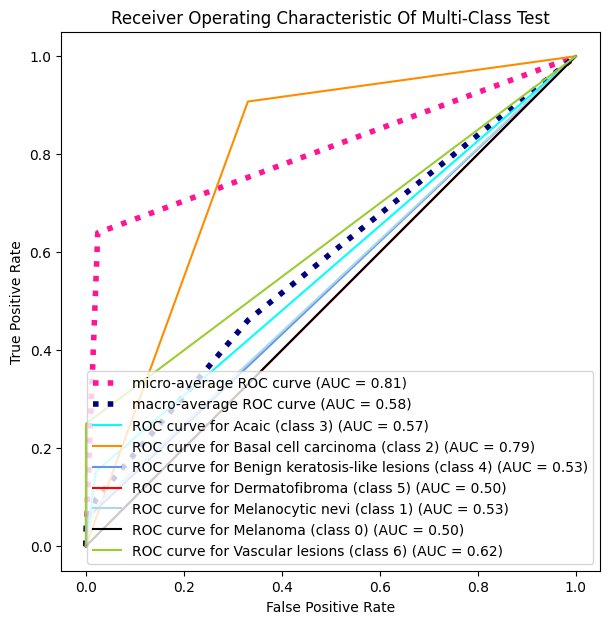

Micro-averaged One-vs-Rest ROC AUC score:
0.80
Macro-averaged One-vs-Rest ROC AUC score:
0.58


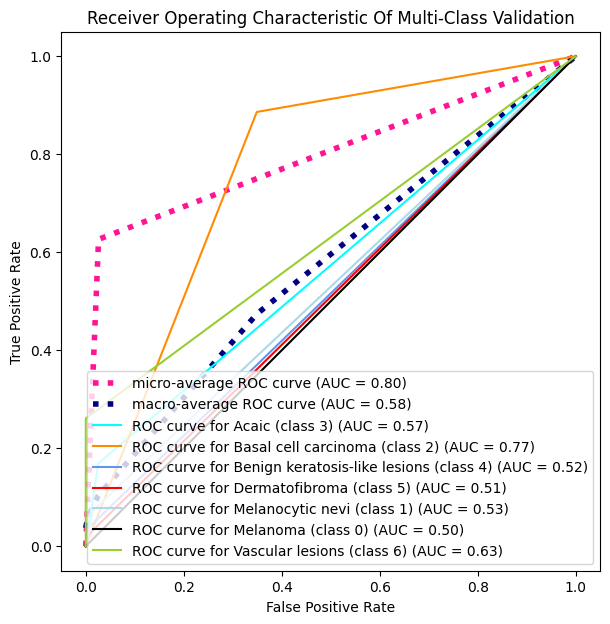

In [20]:
roc_auc(pred_test, tY_test, "Test")
roc_auc(pred_validation, tY_validation, "Validation")

In [21]:
# Performance meaures: (accuracy, sensitivity, specificity, and F1-score)
print(classification_report(tY_test, pred_test, target_names=target_names))
print(pd.DataFrame((cm.diagonal()/cm.sum()), index = target_names, columns=['accuracy']))

                                         precision    recall  f1-score   support

                     Melanoma (class 0)       0.48      0.15      0.23       223
             Melanocytic nevi (class 1)       0.85      0.91      0.88      1341
         Basal cell carcinoma (class 2)       0.43      0.06      0.10       103
                        Acaic (class 3)       0.00      0.00      0.00        65
Benign keratosis-like lesions (class 4)       0.38      0.08      0.13       220
               Dermatofibroma (class 5)       0.00      0.00      0.00        23
             Vascular lesions (class 6)       0.88      0.25      0.39        28

                              micro avg       0.81      0.64      0.72      2003
                              macro avg       0.43      0.21      0.25      2003
                           weighted avg       0.70      0.64      0.64      2003
                            samples avg       0.64      0.64      0.64      2003

                         

In [22]:
n_classes = cm.shape[0]

for i in range(n_classes):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {i}: Sensitivity = {tpr:.2f}, Specificity = {tnr:.2f}")

Class 0: Sensitivity = 0.46, Specificity = 0.78
Class 1: Sensitivity = 0.91, Specificity = 0.67
Class 2: Sensitivity = 0.06, Specificity = 1.00
Class 3: Sensitivity = 0.00, Specificity = 1.00
Class 4: Sensitivity = 0.08, Specificity = 0.98
Class 5: Sensitivity = 0.00, Specificity = 1.00
Class 6: Sensitivity = 0.25, Specificity = 1.00


## Enhanced Model

In [32]:
def model_builder(hp):
    model = Sequential()
    units=hp.Int("units", min_value=8, max_value=64, step=7)
    
    model.add(keras.layers.Conv2D(units, (3, 3), padding = "same", activation = "relu", input_shape = tX_train.shape[1:]))
    model.add(keras.layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    model.add(keras.layers.Dropout(hp.Float("dropout" , 0, 0.4, step=0.1)))
    
    num_layers = hp.Int("num_layers", 0, 3)
    if num_layers>0:
        for i in range(1, num_layers+1):
            model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"))
            model.add(keras.layers.Conv2D(32, (3,3), padding='same', activation="relu"))
            model.add(keras.layers.MaxPooling2D((2, 2)))
            # Tune dropout layer with values from 0 - 0.3 with stepsize of 0.1.
            model.add(keras.layers.Dropout(hp.Float("dropout_" + str(i), 0, 0.4, step=0.1)))
        
        
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation = "relu"))
    model.add(keras.layers.Dense(32, activation = "relu"))
    
    model.add(keras.layers.Dense(7, activation = "softmax"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
    optimizer=hp.Choice('optimizer', values=['adam', 'adagrad', 'rmsprop'])

    model.compile(optimizer=optimizer,
                  loss= tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [42]:
tuner = keras_tuner.RandomSearch(model_builder, objective='val_accuracy', overwrite=True)      
tuner.search(tX_train, tY_train, epochs=10, batch_size=32, validation_data=(tX_validation, tY_validation))
best_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 01m 21s]
val_accuracy: 0.6693699359893799

Best val_accuracy So Far: 0.7230193614959717
Total elapsed time: 00h 22m 02s


In [47]:
best_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
tuned_model = tuner.hypermodel.build(best_hps)

{'units': 43, 'num_layers': 0, 'dropout': 0.2, 'optimizer': 'adam', 'dropout_1': 0.4, 'dropout_2': 0.30000000000000004}


In [49]:
tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 150, 120, 43)      1204      
                                                                 
 conv2d_3 (Conv2D)           (None, 150, 120, 32)      12416     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 75, 60, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 75, 60, 32)        0         
                                                                 
 flatten_1 (Flatten)         (None, 144000)            0         
                                                                 
 dense_3 (Dense)             (None, 32)                4608032   
                                                      

In [54]:
# Fitting model
history = tuned_model.fit(tX_train, tY_train, epochs = 10, batch_size = 32, validation_data = (tX_validation, tY_validation))
test_loss, test_acc = tuned_model.evaluate(tX_test, tY_test)

Epoch 1/10
201/201 [==============================] - 10s 50ms/step - loss: 0.6417 - accuracy: 0.7572 - val_loss: 0.7912 - val_accuracy: 0.7037
Epoch 2/10
201/201 [==============================] - 10s 50ms/step - loss: 0.6135 - accuracy: 0.7705 - val_loss: 0.8662 - val_accuracy: 0.6968
Epoch 3/10
201/201 [==============================] - 10s 50ms/step - loss: 0.5711 - accuracy: 0.7895 - val_loss: 0.7790 - val_accuracy: 0.7180
Epoch 4/10
201/201 [==============================] - 10s 50ms/step - loss: 0.5389 - accuracy: 0.8046 - val_loss: 0.8112 - val_accuracy: 0.7112
Epoch 5/10
201/201 [==============================] - 10s 50ms/step - loss: 0.4896 - accuracy: 0.8242 - val_loss: 0.8736 - val_accuracy: 0.7031
Epoch 6/10
201/201 [==============================] - 10s 50ms/step - loss: 0.4433 - accuracy: 0.8418 - val_loss: 0.8940 - val_accuracy: 0.7062
Epoch 7/10
201/201 [==============================] - 10s 50ms/step - loss: 0.3849 - accuracy: 0.8643 - val_loss: 0.9427 - val_accuracy:

In [55]:
print("val_accuracy:", np.mean(history.history["val_accuracy"]), "val_loss:", np.mean(history.history["val_loss"]))

val_accuracy: 0.7077978789806366 val_loss: 0.9104386866092682


In [56]:
print("test_accuracy", test_acc, "test_loss:",test_loss )

test_accuracy 0.7139291167259216 test_loss: 1.207777500152588


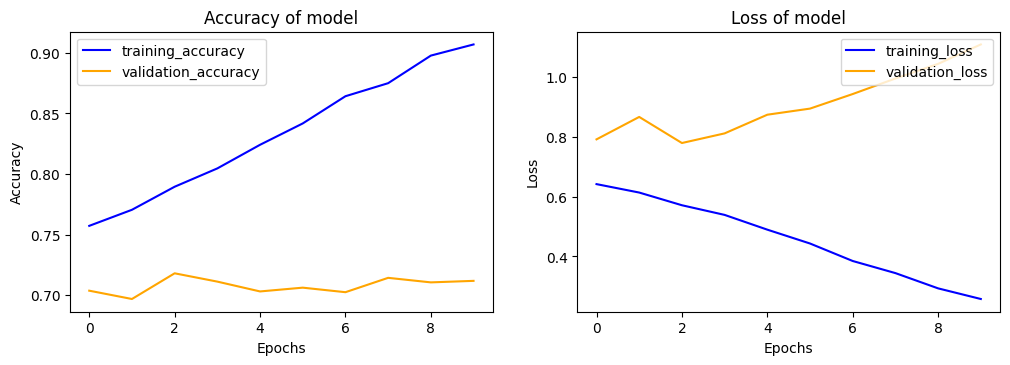

In [57]:
plot_diagnostics(history)

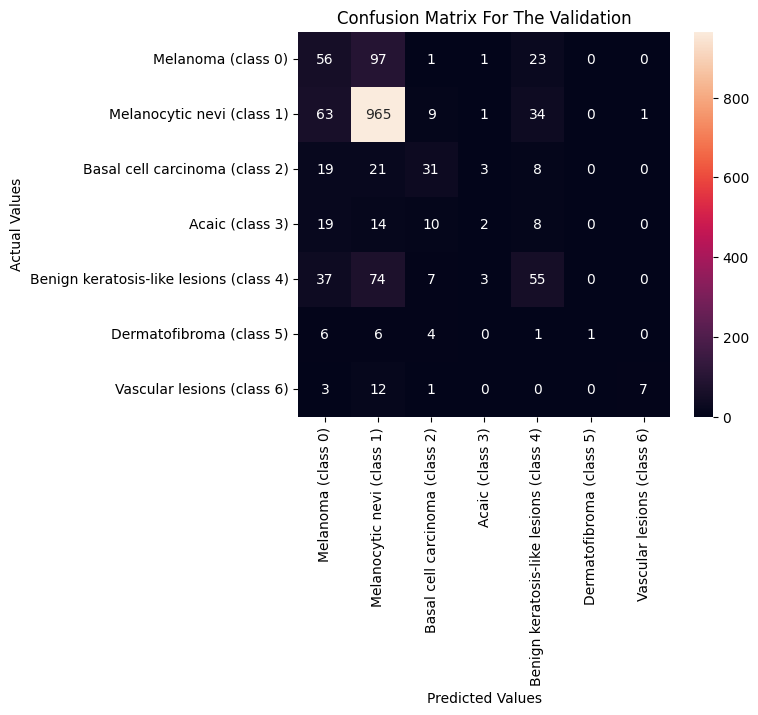

In [58]:
# Confusion matrix for Validiation data
# predict probabilities for test set
yhat_probs = tuned_model.predict(tX_validation, verbose=0)

# predict classes for test set
pred_validation_best=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_validation,axis=1), pred_validation_best.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Validation')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

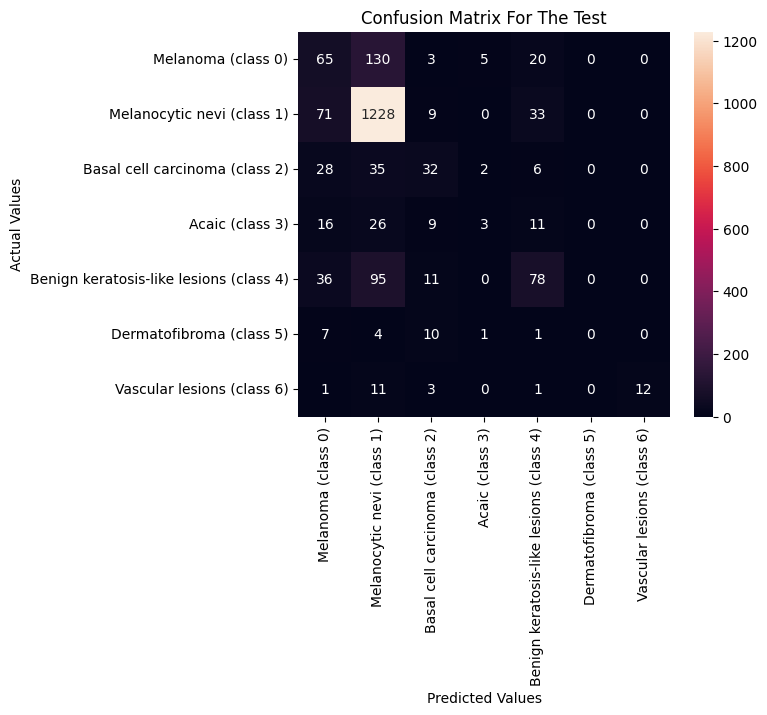

In [59]:
# Confusion matrix for the test data
# predict probabilities for test set
yhat_probs = tuned_model.predict(tX_test, verbose=0)

# predict classes for test set
pred_test_best=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_test,axis=1), pred_test_best.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Test')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Micro-averaged One-vs-Rest ROC AUC score:
0.83
Macro-averaged One-vs-Rest ROC AUC score:
0.62


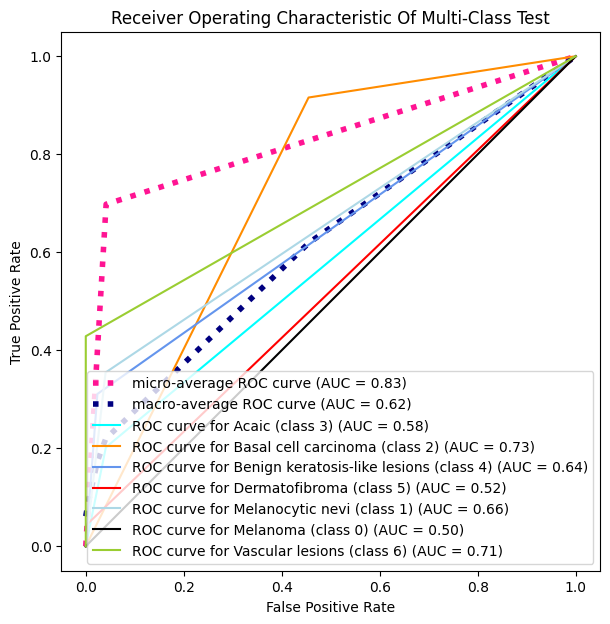

Micro-averaged One-vs-Rest ROC AUC score:
0.83
Macro-averaged One-vs-Rest ROC AUC score:
0.62


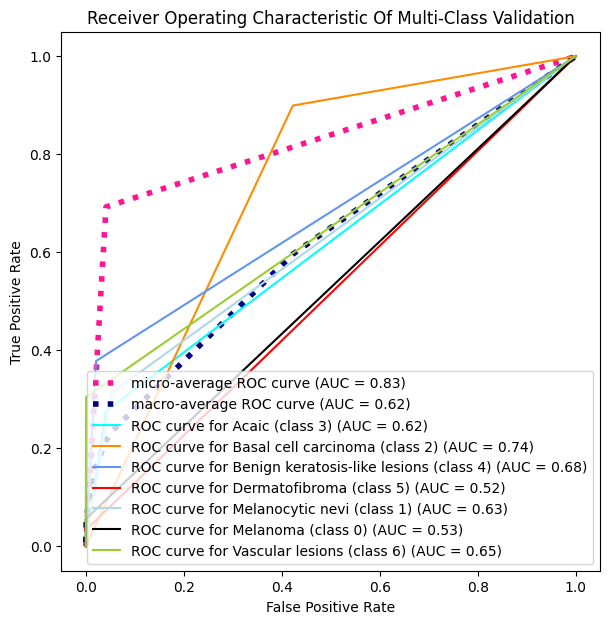

In [60]:
roc_auc(pred_test_best, tY_test, "Test")
roc_auc(pred_validation_best, tY_validation, "Validation")

In [61]:
# Performance meaures: (accuracy, sensitivity, specificity, and F1-score)
print(classification_report(tY_test, pred_test_best, target_names=target_names))
print(pd.DataFrame((cm.diagonal()/cm.sum()), index = target_names, columns=['accuracy']))

                                         precision    recall  f1-score   support

                     Melanoma (class 0)       0.38      0.20      0.26       223
             Melanocytic nevi (class 1)       0.80      0.92      0.86      1341
         Basal cell carcinoma (class 2)       0.42      0.31      0.36       103
                        Acaic (class 3)       0.27      0.05      0.08        65
Benign keratosis-like lesions (class 4)       0.52      0.35      0.42       220
               Dermatofibroma (class 5)       0.00      0.00      0.00        23
             Vascular lesions (class 6)       1.00      0.43      0.60        28

                              micro avg       0.74      0.70      0.72      2003
                              macro avg       0.48      0.32      0.37      2003
                           weighted avg       0.68      0.70      0.68      2003
                            samples avg       0.70      0.70      0.70      2003

                         

In [62]:
n_classes = cm.shape[0]

for i in range(n_classes):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {i}: Sensitivity = {tpr:.2f}, Specificity = {tnr:.2f}")

Class 0: Sensitivity = 0.29, Specificity = 0.91
Class 1: Sensitivity = 0.92, Specificity = 0.55
Class 2: Sensitivity = 0.31, Specificity = 0.98
Class 3: Sensitivity = 0.05, Specificity = 1.00
Class 4: Sensitivity = 0.35, Specificity = 0.96
Class 5: Sensitivity = 0.00, Specificity = 1.00
Class 6: Sensitivity = 0.43, Specificity = 1.00


## Transfer Learning Model

In [63]:
## vgg16
# load model without output layer and specify a new input shape for images
vgg_model = VGG16(include_top = False, input_shape = (150,120,3))
for layer in vgg_model.layers:
    layer.trainable = False
flat1 = layers.Flatten()(vgg_model.layers[-1].output)
print(flat1.shape)
#add Dense layer
class1 = layers.Dense(128, activation='relu')(flat1)
#add output layer with softmax activation
output = layers.Dense(7, activation='softmax')(class1)
# define new model
vgg_model = Model(inputs=vgg_model.inputs, outputs=output)
# summarize
vgg_model.summary()

(None, 6144)
Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 150, 120, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 150, 120, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 150, 120, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 75, 60, 64)        0         
                                                                 
 block2_conv1 (Conv2D)       (None, 75, 60, 128)       73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 75, 60, 128)       147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 37, 30, 128)

In [71]:
vgg_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = vgg_model.fit(tX_train, tY_train, epochs=10, batch_size=32, validation_data=(tX_validation, tY_validation))
test_loss, test_acc = vgg_model.evaluate(tX_test,tY_test)

Epoch 1/10
201/201 [==============================] - 20s 95ms/step - loss: 0.4134 - accuracy: 0.8550 - val_loss: 0.7984 - val_accuracy: 0.7236
Epoch 2/10
201/201 [==============================] - 19s 94ms/step - loss: 0.4001 - accuracy: 0.8599 - val_loss: 0.7931 - val_accuracy: 0.7324
Epoch 3/10
201/201 [==============================] - 19s 94ms/step - loss: 0.3737 - accuracy: 0.8678 - val_loss: 0.8911 - val_accuracy: 0.7392
Epoch 4/10
201/201 [==============================] - 19s 94ms/step - loss: 0.3573 - accuracy: 0.8767 - val_loss: 0.8872 - val_accuracy: 0.7461
Epoch 5/10
201/201 [==============================] - 19s 94ms/step - loss: 0.3374 - accuracy: 0.8864 - val_loss: 0.8935 - val_accuracy: 0.7174
Epoch 6/10
201/201 [==============================] - 19s 94ms/step - loss: 0.3125 - accuracy: 0.8894 - val_loss: 0.9060 - val_accuracy: 0.7143
Epoch 7/10
201/201 [==============================] - 19s 94ms/step - loss: 0.3162 - accuracy: 0.8875 - val_loss: 0.9470 - val_accuracy:

In [72]:
print("val_accuracy:", np.mean(history.history["val_accuracy"]), "val_loss:", np.mean(history.history["val_loss"]))

val_accuracy: 0.7319401204586029 val_loss: 0.8944905996322632


In [73]:
print("test_accuracy", test_acc, "test_loss:",test_loss )

test_accuracy 0.7608587145805359 test_loss: 0.8903377056121826


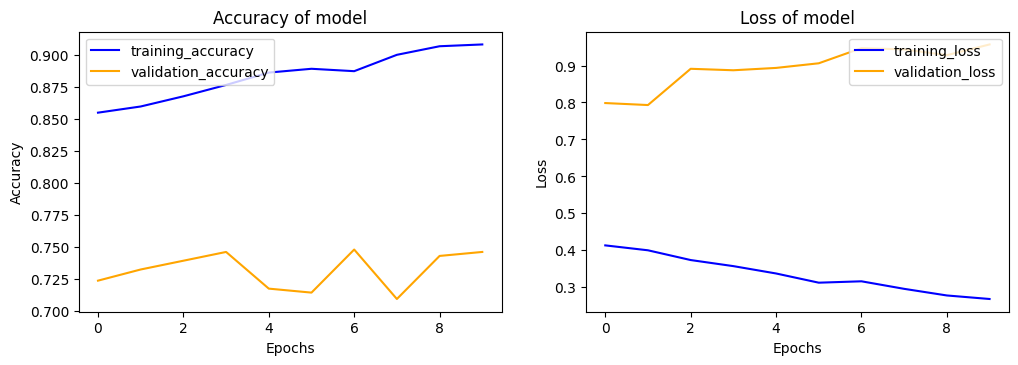

In [74]:
plot_diagnostics(history)

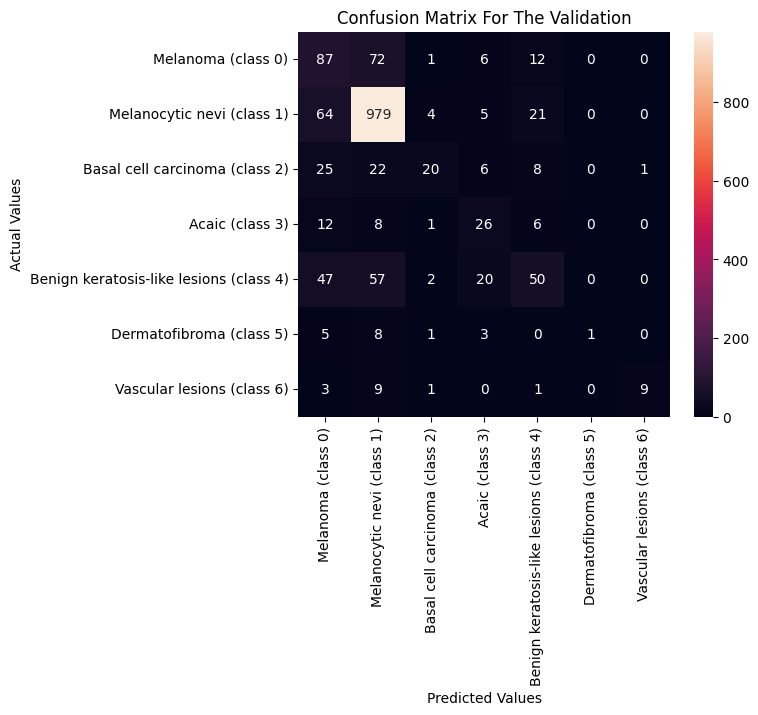

In [75]:
# Confusion matrix for Validiation data
# predict probabilities for test set
yhat_probs = vgg_model.predict(tX_validation, verbose=0)

# predict classes for test set
pred_validation_vgg=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_validation,axis=1), pred_validation_vgg.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Validation')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

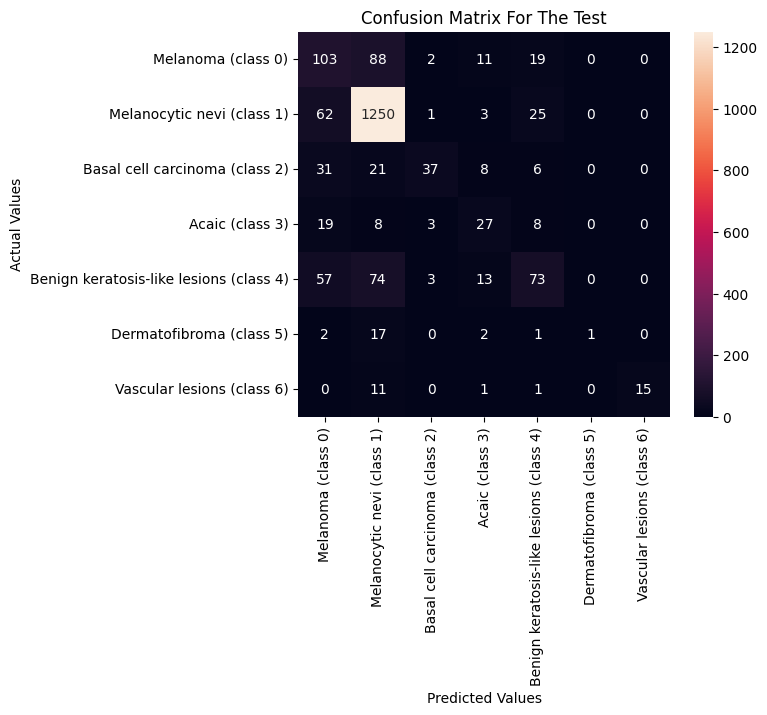

In [76]:
# Confusion matrix for the test data
# predict probabilities for test set
yhat_probs = vgg_model.predict(tX_test, verbose=0)

# predict classes for test set
pred_test_vgg=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_test,axis=1), pred_test_vgg.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Test')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Micro-averaged One-vs-Rest ROC AUC score:
0.85
Macro-averaged One-vs-Rest ROC AUC score:
0.68


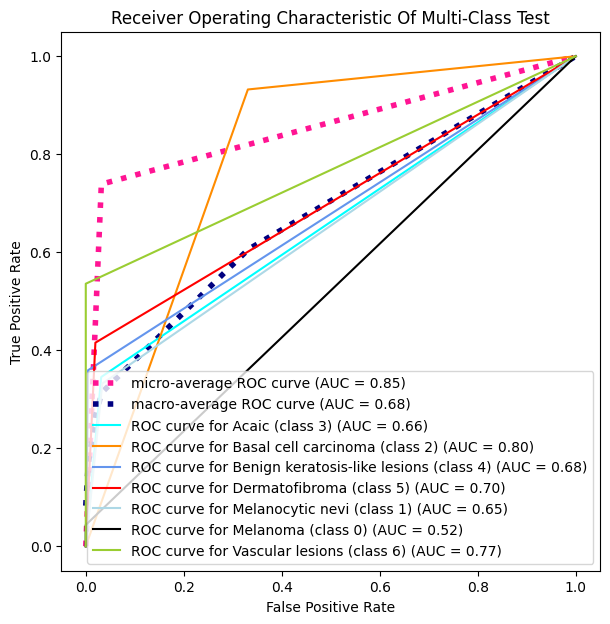

Micro-averaged One-vs-Rest ROC AUC score:
0.84
Macro-averaged One-vs-Rest ROC AUC score:
0.67


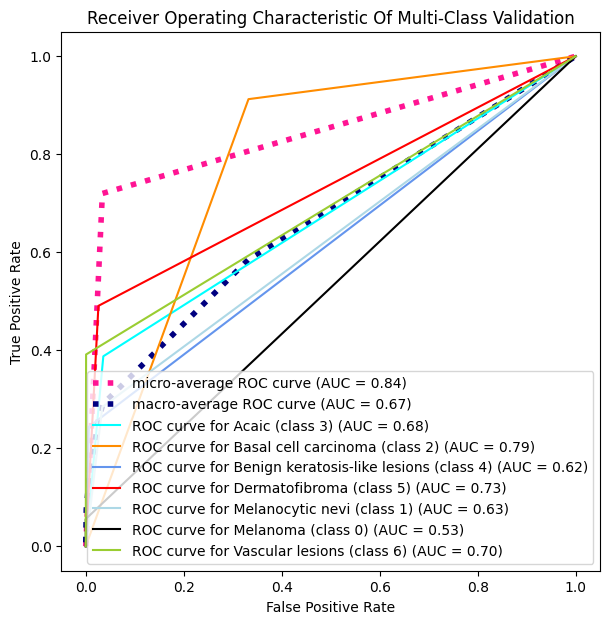

In [77]:
roc_auc(pred_test_vgg, tY_test, "Test")
roc_auc(pred_validation_vgg, tY_validation, "Validation")

In [78]:
# Performance meaures: (accuracy, sensitivity, specificity, and F1-score)
print(classification_report(tY_test, pred_test_vgg, target_names=target_names))
print(pd.DataFrame((cm.diagonal()/cm.sum()), index = target_names, columns=['accuracy']))

                                         precision    recall  f1-score   support

                     Melanoma (class 0)       0.58      0.35      0.43       223
             Melanocytic nevi (class 1)       0.85      0.93      0.89      1341
         Basal cell carcinoma (class 2)       0.80      0.36      0.50       103
                        Acaic (class 3)       0.42      0.42      0.42        65
Benign keratosis-like lesions (class 4)       0.55      0.33      0.41       220
               Dermatofibroma (class 5)       1.00      0.04      0.08        23
             Vascular lesions (class 6)       1.00      0.54      0.70        28

                              micro avg       0.79      0.74      0.77      2003
                              macro avg       0.74      0.42      0.49      2003
                           weighted avg       0.77      0.74      0.74      2003
                            samples avg       0.74      0.74      0.74      2003

                         

In [79]:
n_classes = cm.shape[0]

for i in range(n_classes):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {i}: Sensitivity = {tpr:.2f}, Specificity = {tnr:.2f}")

Class 0: Sensitivity = 0.46, Specificity = 0.90
Class 1: Sensitivity = 0.93, Specificity = 0.67
Class 2: Sensitivity = 0.36, Specificity = 1.00
Class 3: Sensitivity = 0.42, Specificity = 0.98
Class 4: Sensitivity = 0.33, Specificity = 0.97
Class 5: Sensitivity = 0.04, Specificity = 1.00
Class 6: Sensitivity = 0.54, Specificity = 1.00


In [6]:
## resnet50
# load model without output layer and specify a new input shape for images
res_model = ResNet50(include_top = False, input_shape = (150,120,3))
for layer in res_model.layers:
    layer.trainable = False
flat1 = layers.Flatten()(res_model.layers[-1].output)
print(flat1.shape)
#add Dense layer
class1 = layers.Dense(128, activation='relu')(flat1)
#add output layer with softmax activation
output = layers.Dense(7, activation='softmax')(class1)
# define new model
res_model = Model(inputs=res_model.inputs, outputs=output)
# summarize
res_model.summary()

(None, 40960)
Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 150, 120, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv1_pad (ZeroPadding2D)      (None, 156, 126, 3)  0           ['input_1[0][0]']                
                                                                                                  
 conv1_conv (Conv2D)            (None, 75, 60, 64)   9472        ['conv1_pad[0][0]']              
                                                                                                  
 conv1_bn (BatchNormalization)  (None, 75, 60, 64)   256         ['conv1_conv[0]

In [11]:
res_model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])
history = res_model.fit(tX_train, tY_train, epochs=10, batch_size=32, validation_data=(tX_validation, tY_validation))
test_loss, test_acc = res_model.evaluate(tX_test,tY_test)

Epoch 1/10
201/201 [==============================] - 28s 83ms/step - loss: 1.2230 - accuracy: 0.6538 - val_loss: 1.1839 - val_accuracy: 0.6700
Epoch 2/10
201/201 [==============================] - 14s 71ms/step - loss: 1.0988 - accuracy: 0.6720 - val_loss: 1.1206 - val_accuracy: 0.6706
Epoch 3/10
201/201 [==============================] - 14s 71ms/step - loss: 1.0769 - accuracy: 0.6775 - val_loss: 1.0701 - val_accuracy: 0.6744
Epoch 4/10
201/201 [==============================] - 15s 74ms/step - loss: 1.0586 - accuracy: 0.6731 - val_loss: 1.0566 - val_accuracy: 0.6638
Epoch 5/10
201/201 [==============================] - 15s 74ms/step - loss: 1.0259 - accuracy: 0.6817 - val_loss: 1.1387 - val_accuracy: 0.6494
Epoch 6/10
201/201 [==============================] - 15s 73ms/step - loss: 1.0245 - accuracy: 0.6811 - val_loss: 1.0429 - val_accuracy: 0.6588
Epoch 7/10
201/201 [==============================] - 15s 74ms/step - loss: 0.9940 - accuracy: 0.6820 - val_loss: 0.9810 - val_accuracy:

In [12]:
print("val_accuracy:", np.mean(history.history["val_accuracy"]), "val_loss:", np.mean(history.history["val_loss"]))

val_accuracy: 0.6704928278923035 val_loss: 1.0654084742069245


In [13]:
print("test_accuracy", test_acc, "test_loss:", test_loss)

test_accuracy 0.6859710216522217 test_loss: 0.9909374713897705


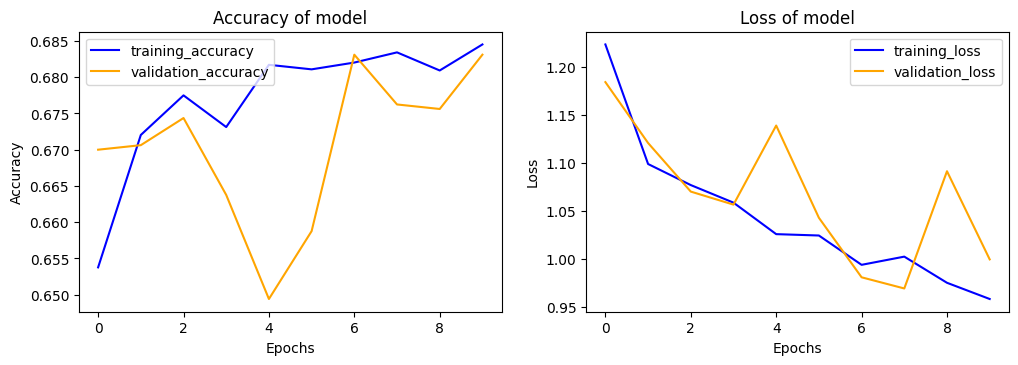

In [17]:
plot_diagnostics(history)

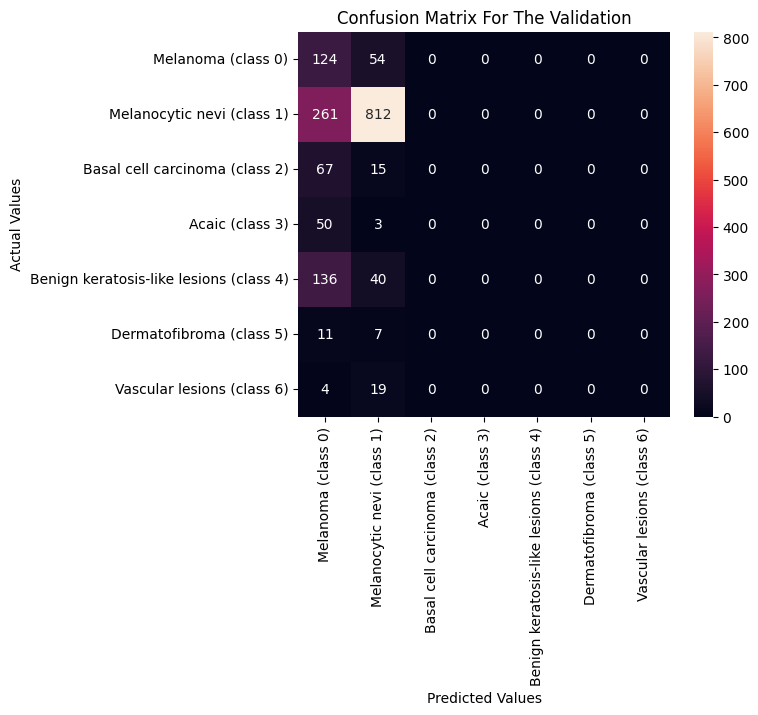

In [19]:
# Confusion matrix for Validiation data
# predict probabilities for test set
yhat_probs = res_model.predict(tX_validation, verbose=0)
# predict classes for test set
pred_validation_res=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_validation,axis=1), pred_validation_res.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Validation')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

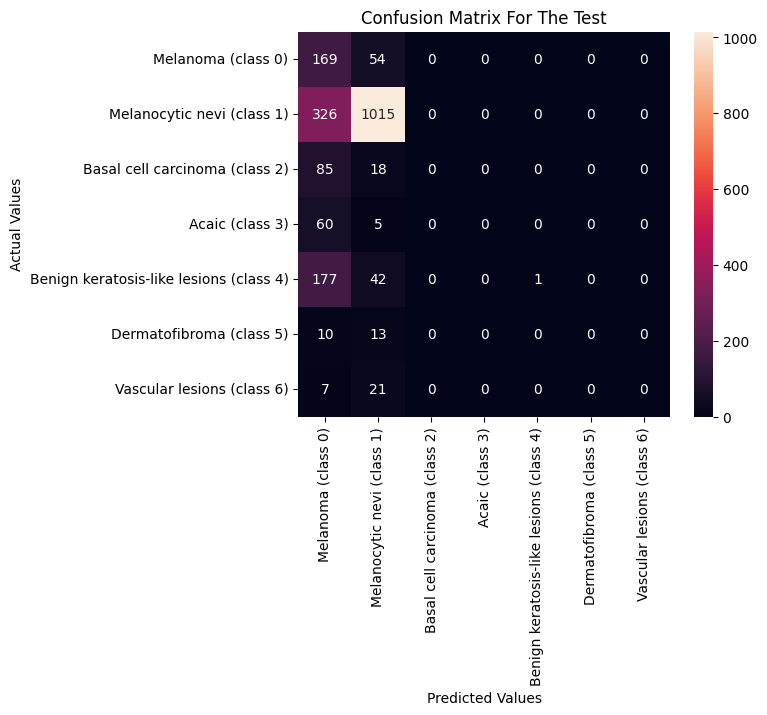

In [20]:
# Confusion matrix for the test data
# predict probabilities for test set
yhat_probs =res_model.predict(tX_test, verbose=0)

# predict classes for test set
pred_test_res=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_test,axis=1), pred_test_res.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Test')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Micro-averaged One-vs-Rest ROC AUC score:
0.75
Macro-averaged One-vs-Rest ROC AUC score:
0.54


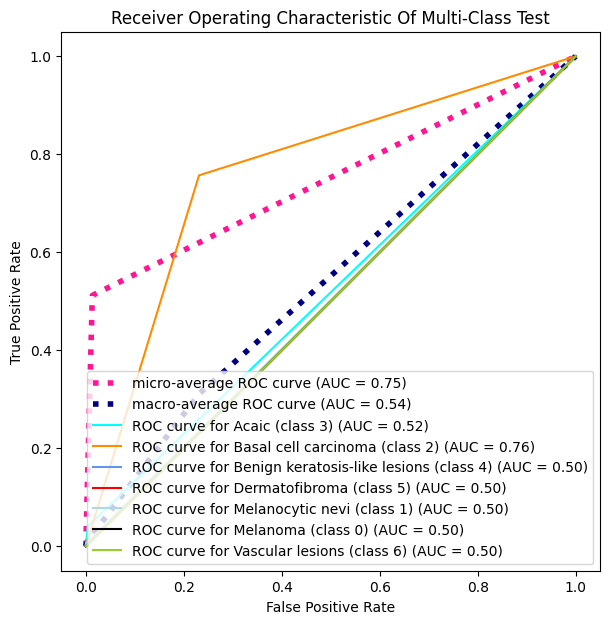

Micro-averaged One-vs-Rest ROC AUC score:
0.75
Macro-averaged One-vs-Rest ROC AUC score:
0.54


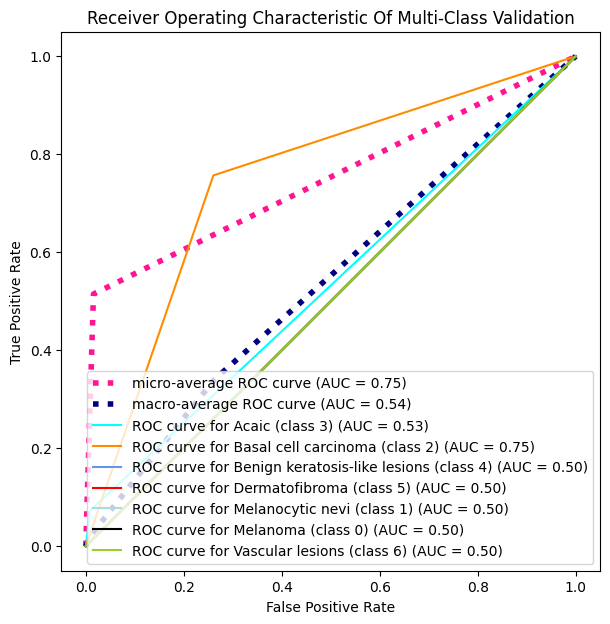

In [22]:
roc_auc(pred_test_res, tY_test, "Test")
roc_auc(pred_validation_res, tY_validation, "Validation")

In [24]:
# Performance meaures: (accuracy, sensitivity, specificity, and F1-score)
print(classification_report(tY_test, pred_test_res, target_names=target_names))
print(pd.DataFrame((cm.diagonal()/cm.sum()), index = target_names, columns=['accuracy']))

                                         precision    recall  f1-score   support

                     Melanoma (class 0)       0.56      0.04      0.08       223
             Melanocytic nevi (class 1)       0.87      0.76      0.81      1341
         Basal cell carcinoma (class 2)       0.00      0.00      0.00       103
                        Acaic (class 3)       0.00      0.00      0.00        65
Benign keratosis-like lesions (class 4)       1.00      0.00      0.01       220
               Dermatofibroma (class 5)       0.00      0.00      0.00        23
             Vascular lesions (class 6)       0.00      0.00      0.00        28

                              micro avg       0.86      0.51      0.64      2003
                              macro avg       0.35      0.11      0.13      2003
                           weighted avg       0.75      0.51      0.55      2003
                            samples avg       0.51      0.51      0.51      2003

                         

In [25]:
n_classes = cm.shape[0]

for i in range(n_classes):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {i}: Sensitivity = {tpr:.2f}, Specificity = {tnr:.2f}")

Class 0: Sensitivity = 0.76, Specificity = 0.63
Class 1: Sensitivity = 0.76, Specificity = 0.77
Class 2: Sensitivity = 0.00, Specificity = 1.00
Class 3: Sensitivity = 0.00, Specificity = 1.00
Class 4: Sensitivity = 0.00, Specificity = 1.00
Class 5: Sensitivity = 0.00, Specificity = 1.00
Class 6: Sensitivity = 0.00, Specificity = 1.00


# Data Augmentation

In [13]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=75,
    width_shift_range=0.3,
    height_shift_range=0.3,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True)
datagen.fit(tX_train)
aug_train = datagen.flow(tX_train, tY_train, batch_size=32)
aug_validation = datagen.flow(tX_validation, tY_validation, batch_size=32)

In [14]:
# fits the model on batches with real-time data augmentation:
aug_model = build_model()
history= aug_model.fit(aug_train, validation_data=aug_validation, batch_size = 32, epochs=10)
test_loss, test_acc = aug_model.evaluate(tX_test, tY_test)

Epoch 1/10
201/201 [==============================] - 38s 186ms/step - loss: 1.0840 - accuracy: 0.6644 - val_loss: 1.0142 - val_accuracy: 0.6694
Epoch 2/10
201/201 [==============================] - 37s 186ms/step - loss: 1.0238 - accuracy: 0.6695 - val_loss: 1.1308 - val_accuracy: 0.6694
Epoch 3/10
201/201 [==============================] - 37s 183ms/step - loss: 1.0063 - accuracy: 0.6692 - val_loss: 0.9754 - val_accuracy: 0.6687
Epoch 4/10
201/201 [==============================] - 37s 184ms/step - loss: 0.9641 - accuracy: 0.6691 - val_loss: 0.9183 - val_accuracy: 0.6700
Epoch 5/10
201/201 [==============================] - 37s 183ms/step - loss: 0.9249 - accuracy: 0.6694 - val_loss: 0.9505 - val_accuracy: 0.6731
Epoch 6/10
201/201 [==============================] - 37s 185ms/step - loss: 0.9121 - accuracy: 0.6705 - val_loss: 0.9210 - val_accuracy: 0.6532
Epoch 7/10
201/201 [==============================] - 39s 195ms/step - loss: 0.9035 - accuracy: 0.6741 - val_loss: 0.8570 - val_ac

In [15]:
print("val_accuracy:", np.mean(history.history["val_accuracy"]), "val_loss:", np.mean(history.history["val_loss"]))

val_accuracy: 0.6692451655864715 val_loss: 0.9382810473442078


In [16]:
print("test_accuracy", test_acc, "test_loss:", test_loss)

test_accuracy 0.6774837970733643 test_loss: 0.8565012216567993


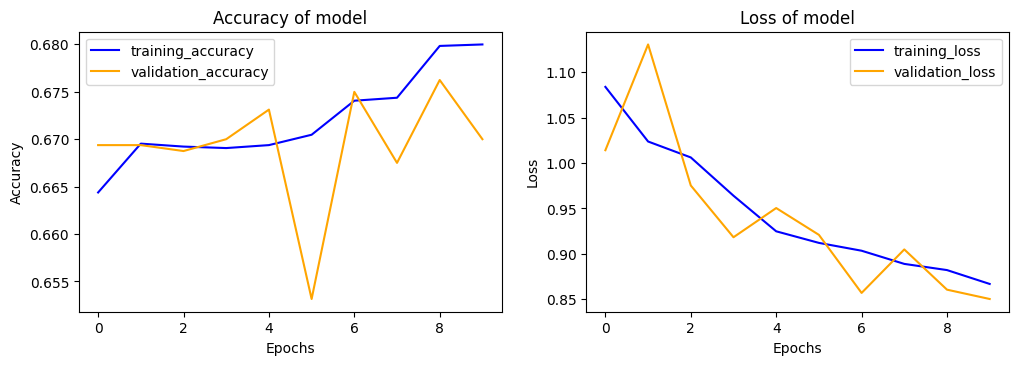

In [17]:
plot_diagnostics(history)

In [37]:
# Performance meaures: (accuracy, sensitivity, specificity, and F1-score)
yhat_probs =aug_model.predict(tX_test, verbose=0)
pred_test_aug=(yhat_probs > 0.5)
cm = confusion_matrix(tf.argmax(tY_test,axis=1), pred_test_aug.argmax(axis=1))

print(classification_report(tY_test, pred_test_aug, target_names=target_names))
print(pd.DataFrame((cm.diagonal()/cm.sum()), index = target_names, columns=['accuracy']))
n_classes = cm.shape[0]
for i in range(n_classes):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {i}: Sensitivity = {tpr:.2f}, Specificity = {tnr:.2f}")

                                         precision    recall  f1-score   support

                     Melanoma (class 0)       0.00      0.00      0.00       223
             Melanocytic nevi (class 1)       0.79      0.88      0.84      1341
         Basal cell carcinoma (class 2)       0.00      0.00      0.00       103
                        Acaic (class 3)       0.00      0.00      0.00        65
Benign keratosis-like lesions (class 4)       0.33      0.01      0.02       220
               Dermatofibroma (class 5)       0.00      0.00      0.00        23
             Vascular lesions (class 6)       0.00      0.00      0.00        28

                              micro avg       0.79      0.59      0.68      2003
                              macro avg       0.16      0.13      0.12      2003
                           weighted avg       0.57      0.59      0.56      2003
                            samples avg       0.59      0.59      0.59      2003

                         

## Tuned augmentation set

In [33]:
tuner = keras_tuner.RandomSearch(model_builder, objective='val_accuracy', overwrite=True)      
tuner.search(aug_train, epochs=10, batch_size=32, validation_data=aug_validation)
aug_tuned_model = tuner.get_best_models()[0]

Trial 10 Complete [00h 06m 08s]
val_accuracy: 0.6706175804138184

Best val_accuracy So Far: 0.6986899375915527
Total elapsed time: 01h 02m 11s


In [34]:
aug_tuned_model = tuner.get_best_models()[0]
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)

{'units': 43, 'num_layers': 3, 'dropout': 0.4, 'optimizer': 'rmsprop', 'dropout_1': 0.0, 'dropout_2': 0.0, 'dropout_3': 0.0}


In [35]:
aug_tuned_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 150, 120, 43)      1204      
                                                                 
 conv2d_1 (Conv2D)           (None, 150, 120, 32)      12416     
                                                                 
 max_pooling2d (MaxPooling2D  (None, 75, 60, 32)       0         
 )                                                               
                                                                 
 conv2d_2 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_3 (Conv2D)           (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 37, 30, 32)       0         
 2D)                                                    

In [36]:
# Fitting model
history = aug_tuned_model.fit(aug_train, epochs = 10, batch_size = 32, validation_data = aug_validation)
test_loss, test_acc = aug_tuned_model.evaluate(tX_test, tY_test)

Epoch 1/10
201/201 [==============================] - 40s 191ms/step - loss: 0.8310 - accuracy: 0.6990 - val_loss: 0.8775 - val_accuracy: 0.6843
Epoch 2/10
201/201 [==============================] - 38s 188ms/step - loss: 0.8265 - accuracy: 0.7014 - val_loss: 0.8088 - val_accuracy: 0.6956
Epoch 3/10
201/201 [==============================] - 38s 188ms/step - loss: 0.8113 - accuracy: 0.7039 - val_loss: 0.7712 - val_accuracy: 0.6999
Epoch 4/10
201/201 [==============================] - 38s 191ms/step - loss: 0.8074 - accuracy: 0.7101 - val_loss: 1.0741 - val_accuracy: 0.6906
Epoch 5/10
201/201 [==============================] - 38s 190ms/step - loss: 0.8092 - accuracy: 0.7031 - val_loss: 0.8344 - val_accuracy: 0.7037
Epoch 6/10
201/201 [==============================] - 38s 190ms/step - loss: 0.8265 - accuracy: 0.7157 - val_loss: 0.7717 - val_accuracy: 0.7280
Epoch 7/10
201/201 [==============================] - 38s 191ms/step - loss: 0.7968 - accuracy: 0.7099 - val_loss: 0.9290 - val_ac

In [38]:
print("val_accuracy:", np.mean(history.history["val_accuracy"]), "val_loss:", np.mean(history.history["val_loss"]))

val_accuracy: 0.7024329423904419 val_loss: 0.8346661388874054


In [39]:
print("test_accuracy", test_acc, "test_loss:",test_loss )

test_accuracy 0.6994508504867554 test_loss: 0.7750603556632996


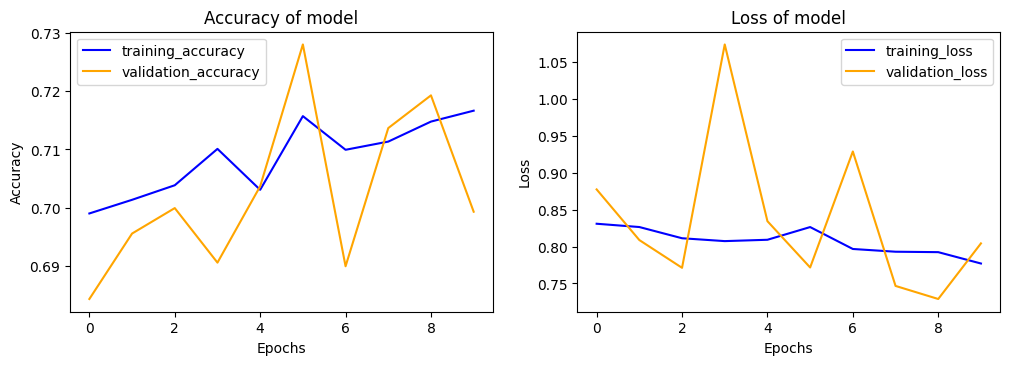

In [40]:
plot_diagnostics(history)

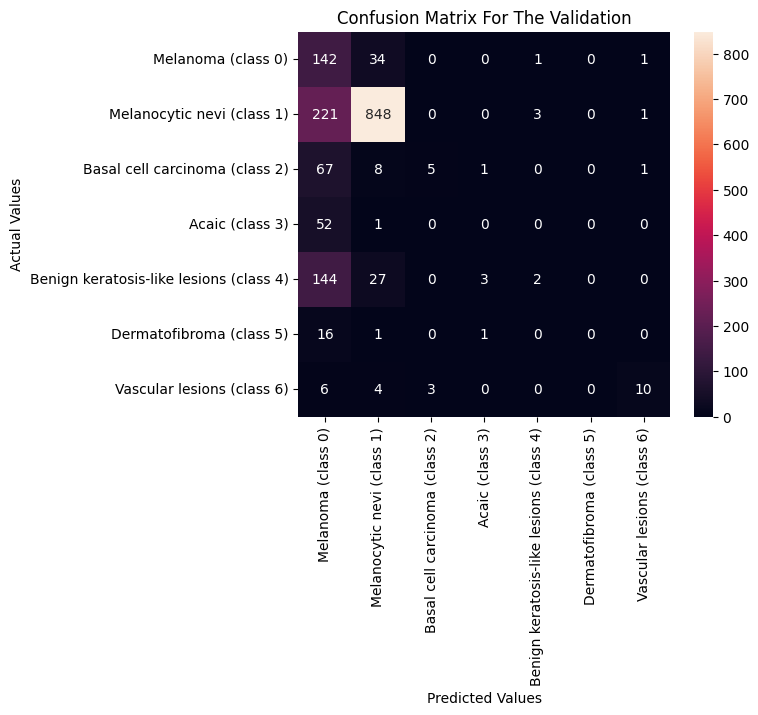

In [41]:
# Confusion matrix for Validiation data
# predict probabilities for test set
yhat_probs = aug_tuned_model.predict(tX_validation, verbose=0)

# predict classes for test set
pred_validation_aug=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_validation,axis=1), tf.argmax(pred_validation_aug,axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Validation')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

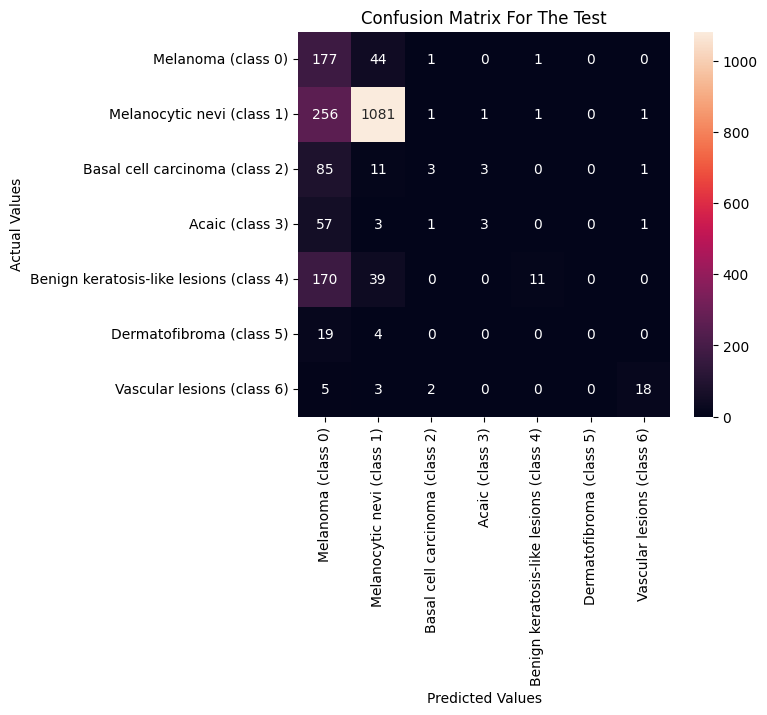

In [42]:
# Confusion matrix for the test data
# predict probabilities for test set
yhat_probs =aug_tuned_model.predict(tX_test, verbose=0)

# predict classes for test set
pred_test_aug=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_test,axis=1), pred_test_aug.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Test')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

In [45]:
# Performance meaures: (accuracy, sensitivity, specificity, and F1-score)
yhat_probs =aug_tuned_model.predict(tX_test, verbose=0)
pred_test_aug=(yhat_probs > 0.5)
cm = confusion_matrix(tf.argmax(tY_test,axis=1), pred_test_aug.argmax(axis=1))

print(classification_report(tY_test, pred_test_aug, target_names=target_names))
print(pd.DataFrame((cm.diagonal()/cm.sum()), index = target_names, columns=['accuracy']))
n_classes = cm.shape[0]
for i in range(n_classes):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {i}: Sensitivity = {tpr:.2f}, Specificity = {tnr:.2f}")

                                         precision    recall  f1-score   support

                     Melanoma (class 0)       0.42      0.33      0.37       223
             Melanocytic nevi (class 1)       0.91      0.81      0.86      1341
         Basal cell carcinoma (class 2)       0.38      0.03      0.05       103
                        Acaic (class 3)       0.43      0.05      0.08        65
Benign keratosis-like lesions (class 4)       0.85      0.05      0.09       220
               Dermatofibroma (class 5)       0.00      0.00      0.00        23
             Vascular lesions (class 6)       0.86      0.64      0.73        28

                              micro avg       0.84      0.59      0.70      2003
                              macro avg       0.55      0.27      0.31      2003
                           weighted avg       0.80      0.59      0.64      2003
                            samples avg       0.59      0.59      0.59      2003

                         

# Experiment on enhanced model

In [55]:
def model_builder_adv(hp):
    model = Sequential()
    
    model.add(keras.layers.Conv2D(43, (3, 3), padding = "same", activation = "relu", input_shape = tX_train.shape[1:]))
    model.add(keras.layers.Conv2D(32, (3, 3), padding = "same", activation = "relu"))
    model.add(keras.layers.MaxPooling2D((2, 2)))
    
    model.add(keras.layers.Conv2D(64, (3,3), padding='same', activation="relu"))
    model.add(keras.layers.Conv2D(32, (3,3), padding='same', activation="relu"))
    model.add(keras.layers.MaxPooling2D((2, 2)))
        
    # Tune the number of units in the first Dense layer
    # Choose an optimal value between 32-512
    # model.add(keras.layers.Dense(units=hp_units, activation='relu'))
    model.add(keras.layers.Flatten())
    model.add(keras.layers.Dense(32, activation = "relu", activity_regularizer = regularizers.L1(hp.Float("L1",0,0.2,step=0.01))))
    model.add(keras.layers.Dense(32, activation = "relu"))
    
    model.add(keras.layers.Dense(7, activation = "softmax"))

    # Tune the learning rate for the optimizer
    # Choose an optimal value from 0.01, 0.001, or 0.0001
#     optimizer=hp.Choice('optimizer', values=['adam', 'adagrad', 'rmsprop'])

    model.compile(optimizer='adam',
                  loss= tf.keras.losses.CategoricalCrossentropy(),
                metrics=['accuracy'])

    return model

In [56]:
tuner = keras_tuner.RandomSearch(model_builder_adv, objective='val_accuracy', overwrite=True, max_trials = 5)      
tuner.search(tX_train, tY_train, epochs=10, batch_size=32, validation_data=(tX_validation, tY_validation))
best_model = tuner.get_best_models()[0]

Trial 5 Complete [00h 02m 19s]
val_accuracy: 0.6943231225013733

Best val_accuracy So Far: 0.6955708265304565
Total elapsed time: 00h 11m 26s


In [57]:
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]
print(best_hps.values)
tuned_model = tuner.hypermodel.build(best_hps)

{'L1': 0.09}


In [58]:
tuned_model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 150, 120, 43)      1204      
                                                                 
 conv2d_5 (Conv2D)           (None, 150, 120, 32)      12416     
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 75, 60, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 75, 60, 64)        18496     
                                                                 
 conv2d_7 (Conv2D)           (None, 75, 60, 32)        18464     
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 37, 30, 32)       0         
 2D)                                                  

In [59]:
# Fitting model
history = tuned_model.fit(tX_train, tY_train, epochs = 10, batch_size = 32, validation_data = (tX_validation, tY_validation))
test_loss, test_acc = tuned_model.evaluate(tX_test, tY_test)

Epoch 1/10
201/201 [==============================] - 15s 69ms/step - loss: 1.3532 - accuracy: 0.6592 - val_loss: 1.1578 - val_accuracy: 0.6694
Epoch 2/10
201/201 [==============================] - 14s 68ms/step - loss: 1.0896 - accuracy: 0.6695 - val_loss: 1.0384 - val_accuracy: 0.6694
Epoch 3/10
201/201 [==============================] - 14s 68ms/step - loss: 1.0337 - accuracy: 0.6695 - val_loss: 1.0126 - val_accuracy: 0.6694
Epoch 4/10
201/201 [==============================] - 14s 68ms/step - loss: 1.0115 - accuracy: 0.6695 - val_loss: 0.9954 - val_accuracy: 0.6694
Epoch 5/10
201/201 [==============================] - 14s 68ms/step - loss: 0.9895 - accuracy: 0.6695 - val_loss: 0.9895 - val_accuracy: 0.6694
Epoch 6/10
201/201 [==============================] - 14s 69ms/step - loss: 0.9700 - accuracy: 0.6695 - val_loss: 0.9838 - val_accuracy: 0.6694
Epoch 7/10
201/201 [==============================] - 14s 68ms/step - loss: 0.9448 - accuracy: 0.6750 - val_loss: 0.9586 - val_accuracy:

In [60]:
print("val_accuracy:", np.mean(history.history["val_accuracy"]), "val_loss:", np.mean(history.history["val_loss"]))

val_accuracy: 0.6770430445671082 val_loss: 0.9949503898620605


In [61]:
print("test_accuracy", test_acc, "test_loss:",test_loss )

test_accuracy 0.6949575543403625 test_loss: 0.9653417468070984


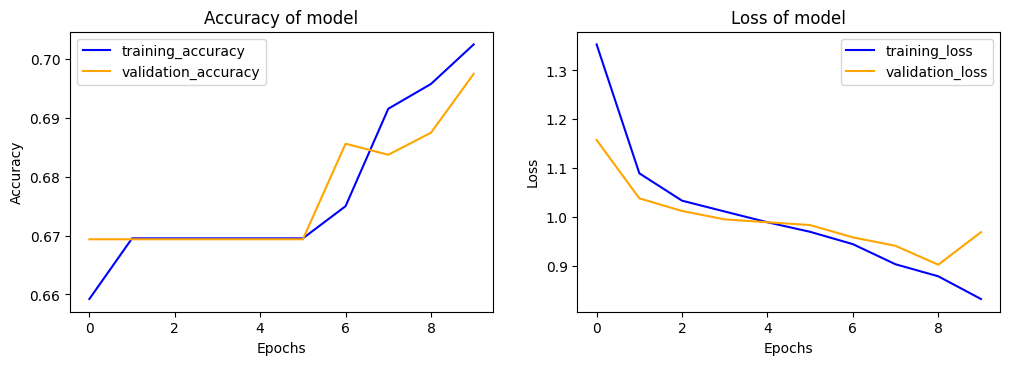

In [62]:
plot_diagnostics(history)

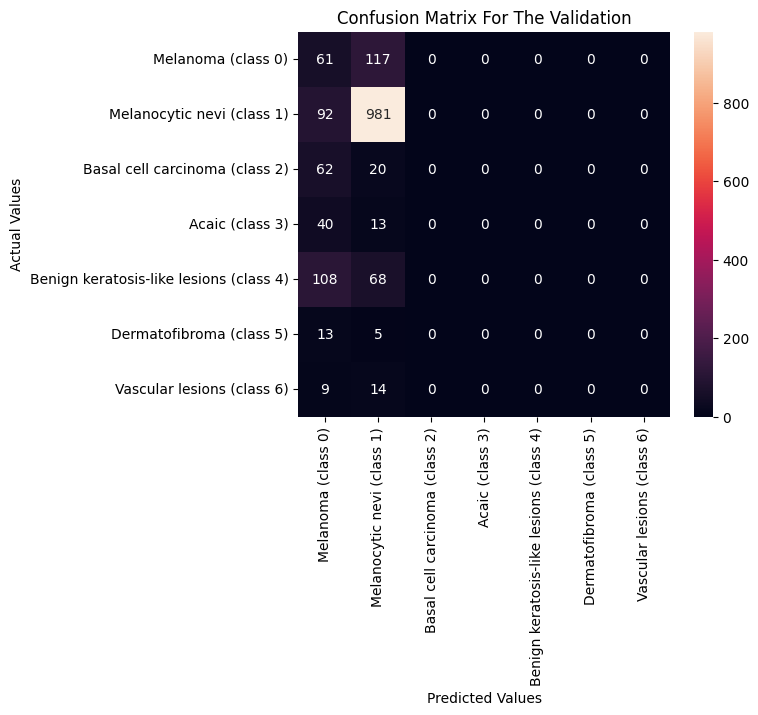

In [63]:
# Confusion matrix for Validiation data
# predict probabilities for test set
yhat_probs = tuned_model.predict(tX_validation, verbose=0)

# predict classes for test set
pred_validation_best=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_validation,axis=1), pred_validation_best.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Validation')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

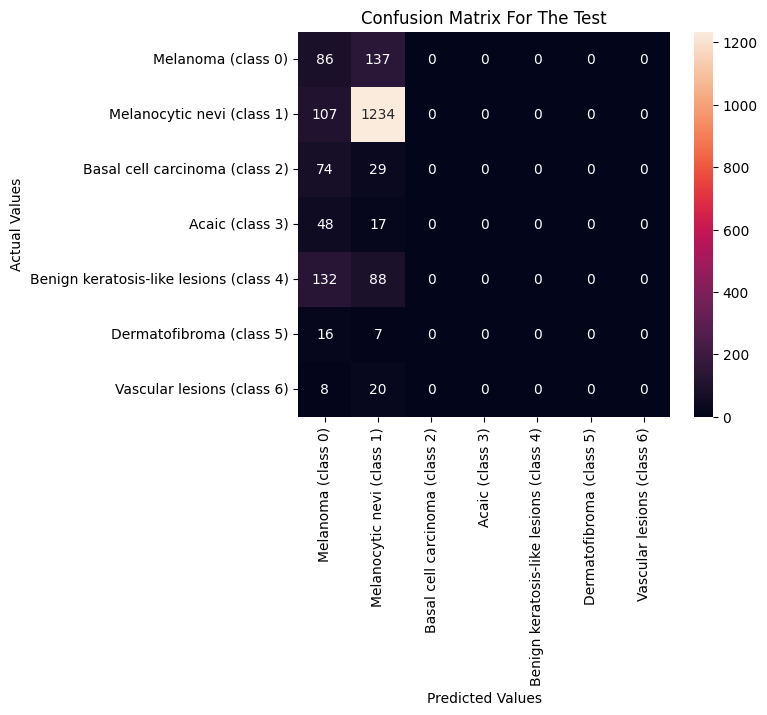

In [64]:
# Confusion matrix for the test data
# predict probabilities for test set
yhat_probs = tuned_model.predict(tX_test, verbose=0)

# predict classes for test set
pred_test_best=(yhat_probs > 0.5)


# This code is adopted from: https://www.google.nl/url?sa=t&rct=j&q=&esrc=s&source=web&cd=&ved=2ahUKEwi-vuTC3dKBAxUOCuwKHa9MAh0QFnoECA8QAQ&url=https%3A%2F%2Fwww.analyticsvidhya.com%2Fblog%2F2021%2F06%2Fconfusion-matrix-for-multi-class-classification%2F&usg=AOvVaw0FWCYbtepbkmj2vp-Iv-5x&opi=89978449
cm = confusion_matrix(tf.argmax(tY_test,axis=1), pred_test_best.argmax(axis=1))
cm_df = pd.DataFrame(cm,
     index = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 'Acaic (class 3)', 
              'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'], 
                     columns = ['Melanoma (class 0)','Melanocytic nevi (class 1)','Basal cell carcinoma (class 2)', 
                                'Acaic (class 3)', 'Benign keratosis-like lesions (class 4)',  'Dermatofibroma (class 5)',  
                               'Vascular lesions (class 6)'])

#Plotting the confusion matrix
plt.figure(figsize=(6,5))
sns.heatmap(cm_df, annot=True, fmt='g')
plt.title('Confusion Matrix For The Test')
plt.ylabel('Actual Values')
plt.xlabel('Predicted Values')
plt.show()

Micro-averaged One-vs-Rest ROC AUC score:
0.80
Macro-averaged One-vs-Rest ROC AUC score:
0.53


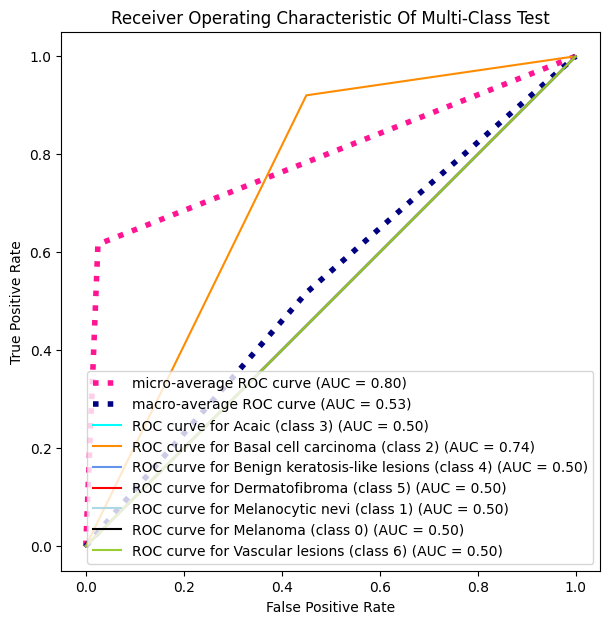

Micro-averaged One-vs-Rest ROC AUC score:
0.79
Macro-averaged One-vs-Rest ROC AUC score:
0.53


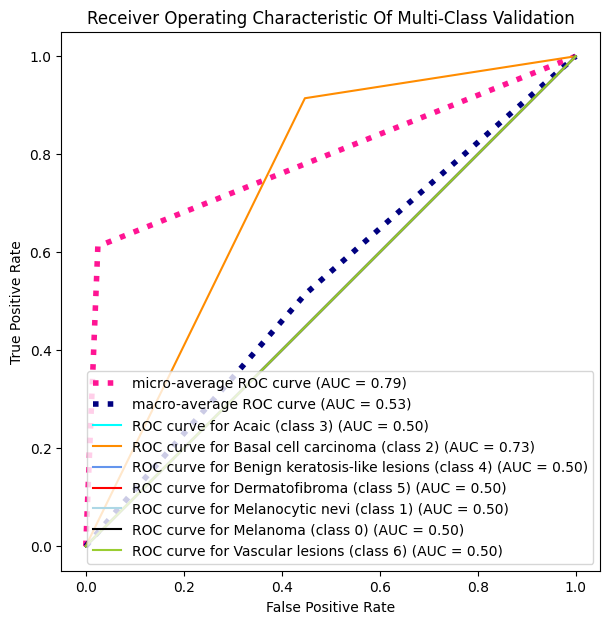

In [65]:
roc_auc(pred_test_best, tY_test, "Test")
roc_auc(pred_validation_best, tY_validation, "Validation")

In [66]:
# Performance meaures: (accuracy, sensitivity, specificity, and F1-score)
print(classification_report(tY_test, pred_test_best, target_names=target_names))
print(pd.DataFrame((cm.diagonal()/cm.sum()), index = target_names, columns=['accuracy']))

                                         precision    recall  f1-score   support

                     Melanoma (class 0)       0.00      0.00      0.00       223
             Melanocytic nevi (class 1)       0.81      0.92      0.86      1341
         Basal cell carcinoma (class 2)       0.00      0.00      0.00       103
                        Acaic (class 3)       0.00      0.00      0.00        65
Benign keratosis-like lesions (class 4)       0.00      0.00      0.00       220
               Dermatofibroma (class 5)       0.00      0.00      0.00        23
             Vascular lesions (class 6)       0.00      0.00      0.00        28

                              micro avg       0.81      0.62      0.70      2003
                              macro avg       0.12      0.13      0.12      2003
                           weighted avg       0.54      0.62      0.58      2003
                            samples avg       0.62      0.62      0.62      2003

                         

In [67]:
n_classes = cm.shape[0]

for i in range(n_classes):
    tp = cm[i, i]
    fn = sum(cm[i, :]) - tp
    fp = sum(cm[:, i]) - tp
    tn = sum(sum(cm)) - tp - fn - fp
    
    tpr = tp / (tp + fn)
    tnr = tn / (tn + fp)
    
    print(f"Class {i}: Sensitivity = {tpr:.2f}, Specificity = {tnr:.2f}")

Class 0: Sensitivity = 0.39, Specificity = 0.78
Class 1: Sensitivity = 0.92, Specificity = 0.55
Class 2: Sensitivity = 0.00, Specificity = 1.00
Class 3: Sensitivity = 0.00, Specificity = 1.00
Class 4: Sensitivity = 0.00, Specificity = 1.00
Class 5: Sensitivity = 0.00, Specificity = 1.00
Class 6: Sensitivity = 0.00, Specificity = 1.00
